In [9]:
import yfinance as yf

In [10]:
sp500 = yf.Ticker('^GSPC')

In [12]:
sp500 = sp500.history(period="max")

In [13]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-16 00:00:00-05:00,6063.790039,6085.189941,6059.140137,6074.080078,4391100000,0.0,0.0
2024-12-17 00:00:00-05:00,6052.549805,6057.680176,6035.189941,6050.609863,4544500000,0.0,0.0
2024-12-18 00:00:00-05:00,6047.649902,6070.669922,5867.790039,5872.160156,5246960000,0.0,0.0


In [46]:
sp500.index


DatetimeIndex(['2015-01-02 00:00:00-05:00', '2015-01-05 00:00:00-05:00',
               '2015-01-06 00:00:00-05:00', '2015-01-07 00:00:00-05:00',
               '2015-01-08 00:00:00-05:00', '2015-01-09 00:00:00-05:00',
               '2015-01-12 00:00:00-05:00', '2015-01-13 00:00:00-05:00',
               '2015-01-14 00:00:00-05:00', '2015-01-15 00:00:00-05:00',
               ...
               '2024-12-09 00:00:00-05:00', '2024-12-10 00:00:00-05:00',
               '2024-12-11 00:00:00-05:00', '2024-12-12 00:00:00-05:00',
               '2024-12-13 00:00:00-05:00', '2024-12-16 00:00:00-05:00',
               '2024-12-17 00:00:00-05:00', '2024-12-18 00:00:00-05:00',
               '2024-12-19 00:00:00-05:00', '2024-12-20 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=2510, freq=None)

<Axes: xlabel='Date'>

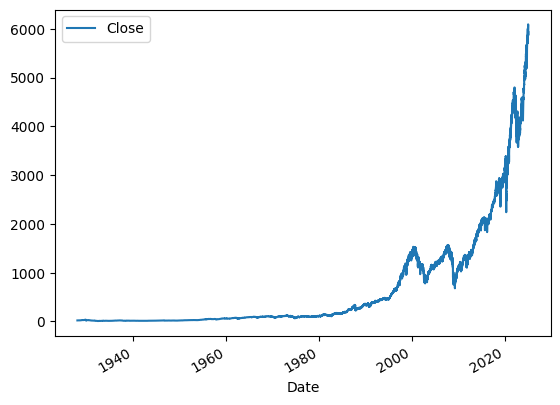

In [15]:
sp500.plot.line(y='Close',use_index=True)

In [27]:
del sp500['Dividends']
del sp500['Stock Splits']

In [29]:
sp500["Tommorrow"] = sp500['Close'].shift(-1)

In [132]:
sp500['Target'] = (sp500['Tommorrow'] >sp500 ['Close']).astype(int)

In [178]:
sp500 = sp500.loc["1990-01-01":].copy()

In [179]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])


RandomForestClassifier(min_samples_split=100, random_state=1)

In [180]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [181]:
import pandas as pd

preds = pd.Series(preds,index=test.index)

In [182]:
precision_score(test["Target"], preds)

0.6129032258064516

In [177]:
combined = pd.concat([test['Target'],preds],axis=1)

<Axes: xlabel='Date'>

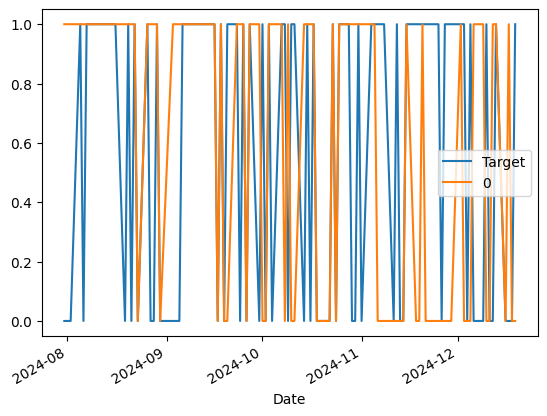

In [157]:
combined.plot()

In [197]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [198]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)
    

In [199]:
predictions = backtest(sp500, model, predictors)

ValueError: No objects to concatenate

In [147]:
predictions['Predictions'].value_counts()
from sklearn.metrics import precision_score
precision_score(predictions['Target'], predictions['Predictions'])


0.3

In [123]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
0    0.7
1    0.3
Name: count, dtype: float64

In [124]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f'Close_Ratio_{horizon}'
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']

    trend_column = f'Trend_{horizon}'
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

    new_predictors += [ratio_column, trend_column]

In [97]:
sp500 = sp500.dropna()

In [99]:
model =RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [100]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:1]
    preds[preds >= .6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions') 
    combined = pd.concat ([test['Target'], preds], axis=1) 
    return combined        


In [108]:
def backtest(data, model, predictors, start=250, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i]
        test = data.iloc[i:i+step]
        predictions = predict(train, test, predictors, model)
        
        if predictions is not None and not predictions.empty:
            all_predictions.append(predictions)
        else:
            print(f"Empty or invalid predictions at step {i}")
    
    if all_predictions:
        return pd.concat(all_predictions)
    else:
        raise ValueError("No valid predictions were generated.")

In [111]:
precision_score(predictions['Target'], predictions['Predictions'])

0.3

In [200]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.7
1    0.3
Name: count, dtype: float64

In [201]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


In [202]:
sp500


,Open,High,Low,Close,Volume,Tommorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2022-12-12 00:00:00-05:00,3939.290039,3990.709961,3935.300049,3990.560059,3904130000,4019.649902,1,1.007089,1.0,1.009572,2.0,1.042514,23.0,0.963873,109.0,1.103598,544.0
2022-12-13 00:00:00-05:00,4069.379883,4100.959961,3993.030029,4019.649902,5079360000,3995.320068,0,1.003632,2.0,1.012913,3.0,1.049566,23.0,0.971548,109.0,1.111130,545.0
2022-12-14 00:00:00-05:00,4015.540039,4053.760010,3965.649902,3995.320068,4472340000,3895.750000,0,0.996964,1.0,1.003677,3.0,1.042581,23.0,0.966296,109.0,1.103939,544.0
2022-12-15 00:00:00-05:00,3958.370117,3958.370117,3879.449951,3895.750000,4493900000,3852.360107,0,0.987382,0.0,0.982007,2.0,1.016130,23.0,0.942876,109.0,1.076008,543.0
2022-12-16 00:00:00-05:00,3890.909912,3890.909912,3827.909912,3852.360107,7493660000,3817.659912,0,0.994400,0.0,0.975101,2.0,1.004401,23.0,0.933021,109.0,1.063622,543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-13 00:00:00-05:00,6068.169922,6078.580078,6035.770020,6051.089844,3584960000,6074.080078,1,0.999987,0.0,0.999378,1.0,1.029776,35.0,1.124631,146.0,1.344326,532.0
2024-12-16 00:00:00-05:00,6063.790039,6085.189941,6059.140137,6074.080078,4391100000,6050.609863,0,1.001896,1.0,1.002472,2.0,1.032601,36.0,1.127786,146.0,1.348720,532.0
2024-12-17 00:00:00-05:00,6052.549805,6057.680176,6035.189941,6050.609863,4544500000,5872.160156,0,0.998064,1.0,0.998081,2.0,1.027644,35.0,1.122359,145.0,1.342808,531.0


In [203]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [204]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [206]:
predictions["Predictions"].value_counts()

Predictions
1    10
Name: count, dtype: int64

In [207]:
precision_score(predictions["Target"], predictions["Predictions"])


0.3

In [208]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.7
1    0.3
Name: count, dtype: float64

In [209]:
predictions

,Target,Predictions
Date,,
2024-12-09 00:00:00-05:00,0,1
2024-12-10 00:00:00-05:00,1,1
2024-12-11 00:00:00-05:00,0,1
2024-12-12 00:00:00-05:00,0,1
2024-12-13 00:00:00-05:00,1,1
2024-12-16 00:00:00-05:00,0,1
2024-12-17 00:00:00-05:00,0,1
2024-12-18 00:00:00-05:00,0,1
2024-12-19 00:00:00-05:00,1,1
